# Convolutional Neural Networks

## From Fully-connected Layers to Convolutions

**Two Principle**:
1. Transition invariance
2. Locality

**Summary:**
1. Translation invariance in images implies that all patches of an image will be treated in the same manner.
2. Locality means that only a small neighborhood of pixels will be used to compute the corresponding hidden representations.
3. In image processing, convolutional layers typically require many fewer parameters than fully-connected layers.
4. CNNS are a special family of neural networks that contain convolutional layers.
5. Channels on input and output allow our model to capture multiple aspects of an image at each spatial location.

## Convolutions for Images 

**The Cross-Correlation Operation** 

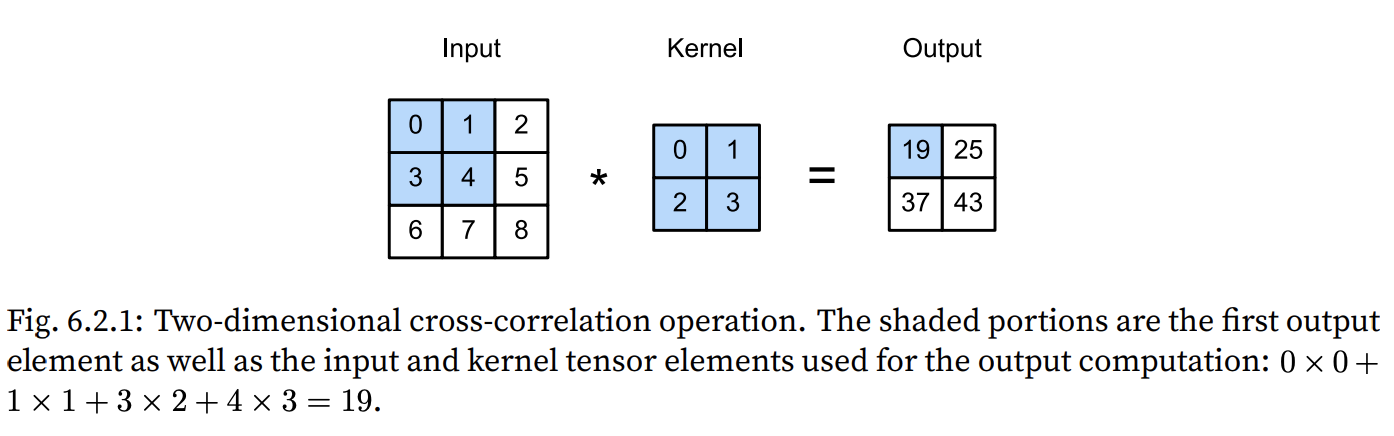

For input size $n_h \times n_w$, convolution kernel size $k_h \times k_w$, we obtain the output size 
$$(n_h - k_h + 1) \times (n_w - k_w + 1).$$

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def corr2d(X, K):
    # implement cross-correlation operation
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [3]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

**Convolutional Layers**

In [4]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

In [5]:
# An application in object edge detection in images
# 1. Construct an image
X = torch.ones((6, 8))
X[:, 2:6] = 0
print(X)
# 2. Construct a kernel
K = torch.tensor([[1.0, -1.0]])
print(K)
# 3. Detect 1 for the edge from white to black and -1 for the edge from black to white
Y = corr2d(X, K)
print(Y)
# 4. The kernel cannot to detect horizontal egdes
corr2d(X.t(), K)

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])
tensor([[ 1., -1.]])
tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])


tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

**Learning a Kernel**

In [6]:
# Construct a 2d convolutional layer
conv2d = nn.Conv2d(1, 1, kernel_size=(1, 2), bias=False)

# input and ouput (example, channel, height, width)
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2

for i in range(10):
    Y_hat = conv2d(X)
    loss = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    loss.sum().backward()
    # update the kernel
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {loss.sum(): .3f}')

epoch 2, loss  0.846
epoch 4, loss  0.185
epoch 6, loss  0.048
epoch 8, loss  0.015
epoch 10, loss  0.005


In [7]:
conv2d.weight.data

tensor([[[[ 1.0030, -0.9885]]]])

**Receptive Field**  
In CNNs, for any element $x$ of some layer, its *receptive field* refers to all the elements (from all the previous layers) that may affect the calculation of $x$ during the forward propagation.   
Note that the receptive field may be larger than the actual
size of the input.  

**Summary**:
1. The core computation of a two-dimensional convolutional layer is a two-dimensional crosscorrelation operation. In its simplest form, this performs a cross-correlation operation on the two-dimensional input data and the kernel, and then adds a bias.
2. We can design a kernel to detect edges in images.
3. We can learn the kernelʼs parameters from data.
4. With kernels learned from data, the outputs of convolutional layers remain unaffected regardless of such layersʼ performed operations (either strict convolution or crosscorrelation).
5. When any element in a feature map needs a larger receptive field to detect broader features on the input, a deeper network can be considered.

## Padding and Stride 

**Padding**  
e.g. For an input $3 \times 3$, through padding, we increase its size to $5 \times 5$.

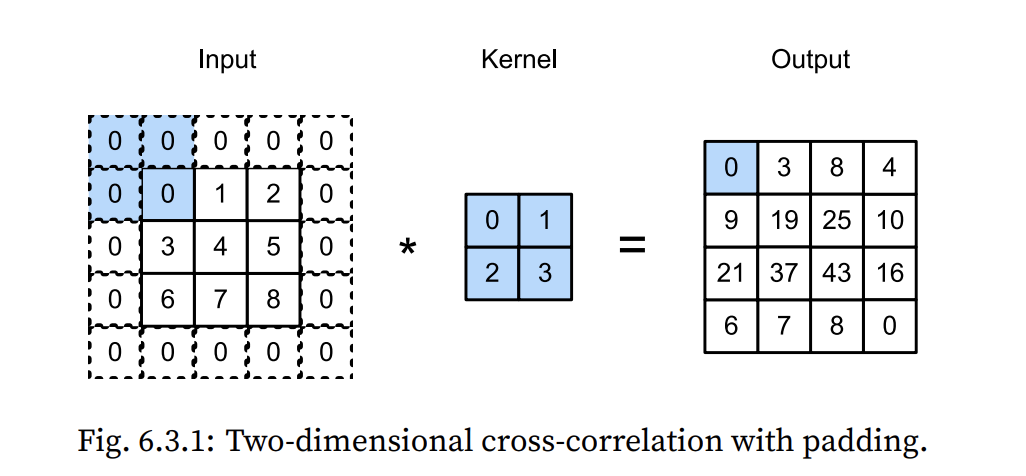

For input size $n_h \times n_w$, convolution kernel size $k_h \times k_w$, if padding with $p_h$ rows and $p_w$ columns, we obtain the output size 
$$(n_h - k_h + p_h + 1) \times (n_w - k_w + p_w + 1).$$

**Note**:
1. By setting $p_h=k_h-1$ and $p_w=k_w-1$ to keep the input size and output size be same. This will make it easier to predict the output shape of each layerwhen constructing the network.
2. Assuming that $k_h$ is odd here, we will pad $p_h/2$ rows on both sides of the height. If $k_h$ is even, one possibility is to pad $\lceil p_h/2\rceil$ rows on the top of the input and $\lfloor p_h/2\rfloor$ rows on the bottom. We will pad both sides of the width in the same way.
3. CNNs commonly use convolution kernels with odd height and width values, such as 1, 3, 5, or 7. Choosing odd kernel sizes has the **benefit** that we can preserve the spatial dimensionality while padding with the same number of rows on top and bottom, and the same number of columns on left and right.

In [8]:
import torch
from torch import nn

def comp_conv2d(conv2d, X):
    X = X.reshape((1, 1) + X.shape) # ( , , , ) 4d tuple
    Y = conv2d(X)
    return Y.reshape(Y.shape[2:])

conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1) 
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

In [9]:
# Here, we use a convolution kernel with a height of 5 and a width of 3. The
# padding numbers on either side of the height and width are 2 and 1,
# respectively
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

**Stride**

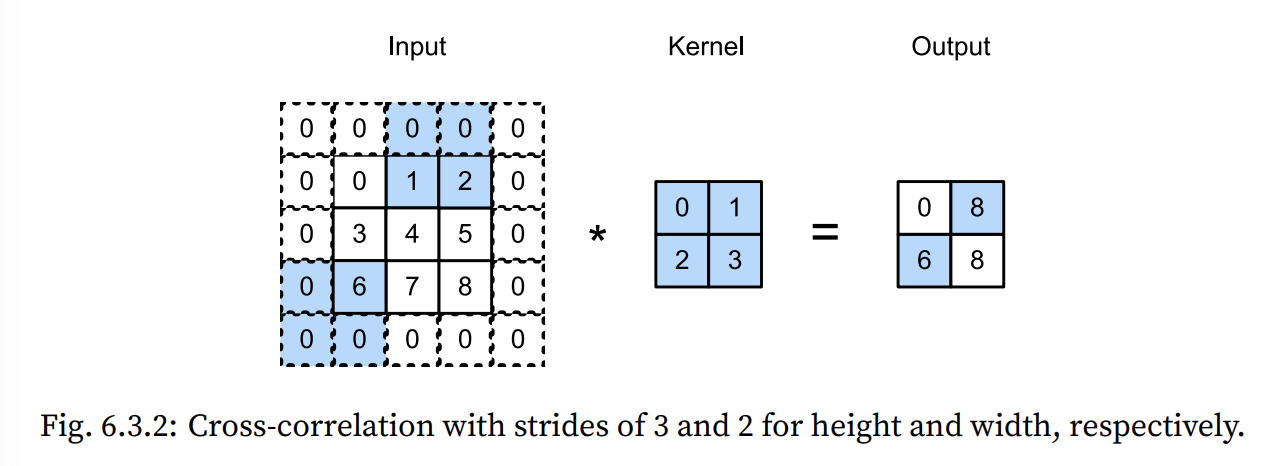

For input size $n_h \times n_w$, convolution kernel size $k_h \times k_w$, the stride for the height is $s_h$ and the stride for the width is $s_w$, if padding with $p_h$ rows and $p_w$ columns, we obtain the output size 
$$\lfloor(n_h-k_h+p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+p_w+s_w)/s_w\rfloor.$$
**Note**:  
1. If set $p_h=k_h-1$ and $p_w=k_w-1$, then the output shape will be simplified to $\lfloor(n_h+s_h-1)/s_h\rfloor \times \lfloor(n_w+s_w-1)/s_w\rfloor$.
2. If the input height and width are divisible by the strides on the height and width, then the output shape will be $(n_h/s_h) \times (n_w/s_w)$.

In [10]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

In [11]:
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

When the padding number
on both sides of the input height and width are $p_h$ and $p_w$ respectively, we call the padding $(p_h, p_w)$.
Specifically, when $p_h = p_w = p$, the padding is $p$.  
When the strides on the height and width are $s_h$ and $s_w$, respectively,
we call the stride $(s_h, s_w)$.
Specifically, when $s_h = s_w = s$, the stride is $s$.  
By default, the padding is 0 and the stride is 1.
In practice, we rarely use inhomogeneous strides or padding,
i.e., we usually have $p_h = p_w$ and $s_h = s_w$.

**Summary**:
1. Padding can increase the height and width of the output. This is often used to give the output the same height and width as the input.
2. The stride can reduce the resolution of the output, for example reducing the height and width of the output to only $1/n$ of the height and width of the input ($n$ is an integer greater than $1$).
* Padding and stride can be used to adjust the dimensionality of the data effectively.

## Multiple Input and Multiple Output Channels 

**Multiple Input channels**  
The num of a convolutional kernel's channels is the same as the num of input data's channels.  
An example of a two-dimensional **cross-correlation** with two input channels.

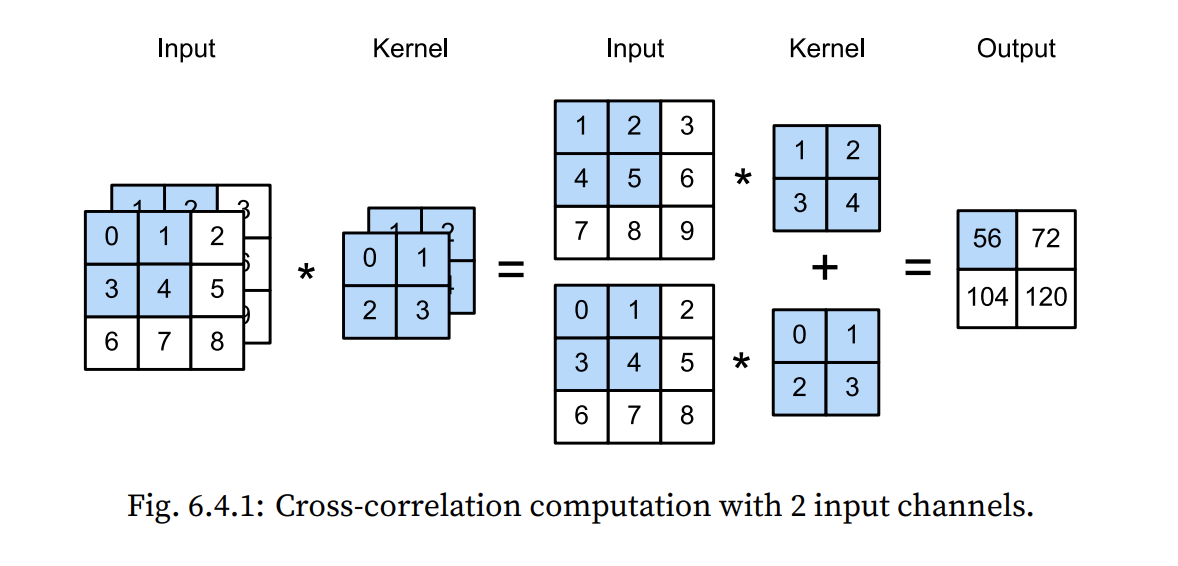

In [12]:
import torch
from d2l import torch as d2l

In [13]:
def corr2d_multi_in(X, K):
    # implemrnt cross-correlation opertions with multiple input channels
    return sum(d2l.corr2d(x, k) for (x, k) in zip(X, K))

In [14]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
[[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

In [15]:
corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

**Multiple Output Channels**  
In the most popular neural network architectures, we actually increase the channel
dimension as we go higher up in the neural network, typically downsampling to trade off spatial
resolution for greater channel depth.  
Input channels: $c_i$  
Output channels: $c_o$
Kernel size: $k_h \times k_w$
From the above notations, we know the shape of the convolution kernel is $c_o \times c_i \times k_h \times k_w$.

In [16]:
def corr2d_multi_in_out(X, K):
    # implement a cross-correlation function to calculate the output of multiple channels
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

In [17]:
# construct a kernel with 3 output channels
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

In [18]:
[k for k in K]

[tensor([[[0., 1.],
          [2., 3.]],
 
         [[1., 2.],
          [3., 4.]]]),
 tensor([[[1., 2.],
          [3., 4.]],
 
         [[2., 3.],
          [4., 5.]]]),
 tensor([[[2., 3.],
          [4., 5.]],
 
         [[3., 4.],
          [5., 6.]]])]

In [19]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

**$1 \times 1$ Covolutional Layer**

*Drawback*: losing the ability of larger convolutional layers to recognize patterns consisting of interactions among adjacent elements in the height and width dimensions.  
*Advantage*: adjust the number of channels between
network layers and control model complexity.

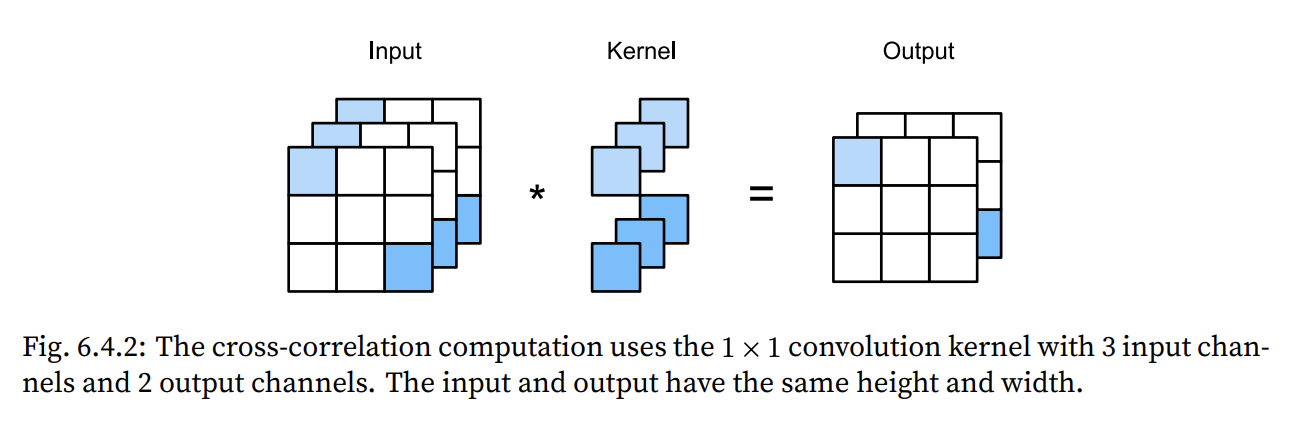

In [20]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

In [21]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))

In [22]:
Y1 = corr2d_multi_in_out(X, K)
Y2 = corr2d_multi_in_out_1x1(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

**Summary**:
1. Multiple channels can be used to extend the model parameters of the convolutional layer.
2. The $1 \times 1$ convolutional layer is equivalent to the fully-connected layer, when applied on a per pixel basis.
3. The $1 \times 1$ convolutional layer is typically used to adjust the number of channels between network layers and to control model complexity.

## Pooling 

**Maximum Pooling and Average Pooling**  
*Pooling* operators consist of a fixed-shape window that is slid over all regions in the input according to its stride, computing a single output for each location traversed
by the fixed-shape window.  
**Note**: The pooling layer contains no parameters.  

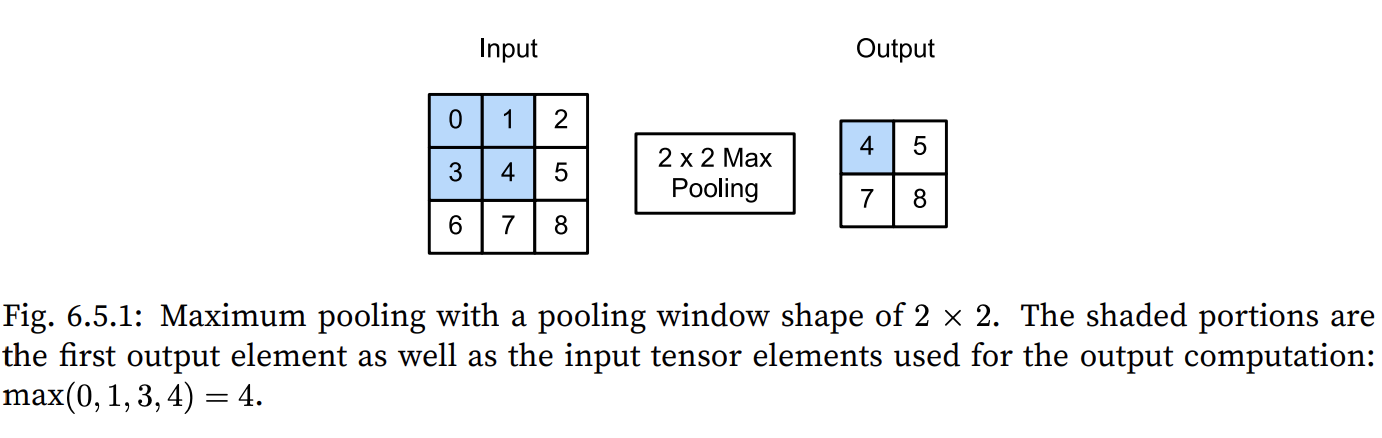

A pooling layer with a pooling window shape of $p \times q$ is called a $p \times q$ pooling layer. The pooling operation is called $p \times q$ pooling.

In [23]:
import torch
from torch import nn
from d2l import torch as d2l

In [24]:
def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode =='avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
                
    return Y

In [25]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [26]:
pool2d(X, (2, 2), mode='avg')

tensor([[2., 3.],
        [5., 6.]])

**Padding and Stride**  
We can use padding and stride in pooling layers.

In [27]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4)) # (num_examples, num_channels, height, width)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [28]:
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

In [29]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [30]:
# specify an arbitrary rectangular pooling window and specify the padding and stride for height and width, respectively.
pool2d = nn.MaxPool2d((2, 3), stride=(2, 3), padding=(0, 1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

**Multiple Channels**  
**Note**: The number of output channels for the pooling layer is the same as the number of input channels.

In [31]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4)) # (num_examples, num_channels, height, width)
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [32]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

**Summary**:
1. Taking the input elements in the pooling window, the maximum pooling operation assigns the maximum value as the output and the average pooling operation assigns the average value as the output.
2. One of the major **benefits** of a pooling layer is to alleviate the excessive sensitivity of the convolutional layer to location.
3. We can specify the padding and stride for the pooling layer.
4. Maximum pooling, combined with a stride larger than 1 can be used to **reduce the spatial dimensions** (e.g., width and height).
5. The pooling layerʼs number of output channels is the same as the number of input channels, **i.e. pooling operation cannot change the number of channels**.